# Clasificador Naive Bayes

En este notebook se entrena un clasificador Naive Bayes para el set de datos `house-votes-84.data` que sea capaz de generar predicciones correctas para un conjunto de datos no visto en entrenamiento.

### Tabla de Contenidos

- [Carga de datos](#Carga-de-datos)
- [Análisis descriptivo de los datos](#Análisis-descriptivo-de-los-datos)
- [Preparación del dataframe](#Preparación-del-dataframe)
- [Conjuntos de entrenamiento y validación](#Conjuntos-de-entrenamiento-y-validación)
- [Entrenamiento del clasificador](#Entrenamiento-del-clasificador)
- [Validación del clasificador](#Validación-del-clasificador)
- [Otros clasificadores Naive Bayes](#Otros-clasificadores-Naive-Bayes)
  - [Bernoulli NB](#Bernoulli-NB)
  - [Multinomial NB](#Multinomial-NB)
- [Extra - Binarización de variables categóricas](#Extra---Binarización-de-variables-categóricas)
- [Conclusiones](#Conclusiones)

### Funciones auxiliares

Funciones auxiliares para facilitar la comprensión y limpieza del código.

In [1]:
import os
import errno

# Función para validar que el fichero existe
def assert_fichero(nombre):
    if (not os.path.isfile(nombre)):
        raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), nombre)

# Separa una variable categórica en tantas columnas como categorías tiene
# marcando a 1 la columna asociada al valor de la variable y el resto a 0
from sklearn.preprocessing import LabelBinarizer
def separar_categorias(df, feature):
    """
    Separa la feature en tantas columnas como categorías hay marcando
    a 1 la columna asociada al valor de la feature y el resto a 0
    Por ejemplo: c1 -> c1_y | c1_n | c1_?
                  y      1      0      0
    """
    lb_style = LabelBinarizer()
    lb_results = lb_style.fit_transform(df[feature])
    
    # Concatena el nombre de la feature con el valor de la categoría
    columnas = list(map(lambda x: '{}_{}'.format(feature, x), lb_style.classes_))
    
    return pd.DataFrame(lb_results, columns=columnas)

# Función para representar la curva ROC
def representar_curva_roc(fpr, tpr, roc_auc, nombre_imagen=None):
    plt.figure()
    lw = 2
    
    if isinstance(fpr, dict):
        for clave in fpr.keys():
            plt.plot(fpr[clave], tpr[clave], lw=lw,
                     label='Curva ROC %s (area = %0.2f)' % (clave, roc_auc[clave]))
    else:
        plt.plot(fpr, tpr, color='darkorange', lw=lw,
                 label='Curva ROC (area = %0.2f)' % roc_auc)
                     
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
        
    if (nombre_imagen):
        plt.savefig('{}.pdf'.format(nombre_imagen), format='pdf')
        
    plt.show()

"""
Calcula y representa la curva ROC y el área bajo la curva (AUC)
Devuelve
roc_auc => área bajo la curva
fpr => tasa de falsos positivos
tpr => tasa de verdaderos positivos
"""
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
def calcular_y_representar_curva_roc(esperado, predicho, representar_curva=True, nombre_imagen=None):
    fpr, tpr, _ = roc_curve(esperado, predicho)
    roc_auc = auc(fpr, tpr)

    if (representar_curva):
        representar_curva_roc(fpr, tpr, roc_auc, nombre_imagen)
    
    return roc_auc, fpr, tpr

### Carga de datos

El primer paso será cargar los módulos necesarios de Python y leer el archivo de datos `house-votes-84.data` que se almacenará en el dataframe `df`.

Para hacer más legible el dataframe, se asignan nombres a las columnas para diferenciar la variable a predecir o *target*: `democrat` y las variables independientes o *features*: `cN`.

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

# Comprobación de que el fichero existe
nombre_dataset = 'house-votes-84.data'
assert_fichero(nombre_dataset)

# Se carga el archivo con el conjunto de datos como un dataframe de pandas
df = pd.read_csv(nombre_dataset,
                 header=None # El archivo de lectura no contiene cabecera
                )

# Asigna nombres a las columnas: democrat, c1, c2, c3, ..., c16
clave_predecir = 'democrat'
claves_predictoras = list(map(lambda x: 'c%d' % x, range(1, 17)))
                          
df.columns = [clave_predecir] + claves_predictoras

### Análisis descriptivo de los datos

El conjunto de datos está compuesto por 435 registros y 17 columnas.

La primera columna hace referencia al bando del votante y puede tomar los valores `democrat` o `republican`. Es decir, se trata de una variable categórica y binaria, porque el votante sólo puede ser de uno de los dos grupos. Esta será la variable *target* para la que se entrenará el clasificador.

Por otro lado, el resto de columnas, de la 2 a la 17, son las votaciones de cada uno de los votantes a distintas votaciones. Cada una de estas columnas puede tener 3 valores diferentes: `y`, `n` o `?`. Estas serán las variable independientes o *features* que servirán para determinar el bando del votante.

Según se indica en el documento `house-votes-84.names`, `?` no indica que se desconozca el valor de la votación sino que el votante no voto ni `y` ni `n`, pero votó algo, por ejemplo: *voto nulo*. Por lo que este valor también puede tener asociado un peso que ayude al sistema predictor a determinar si el votante es demócrata o republicano.

> NOTE: It is important to recognize that "?" in this database does 
         not mean that the value of the attribute is unknown.  It 
         means simply, that the value is not "yea" or "nay" (see 
         "Relevant Information" section above).

Por esto, `?` no se va a tratar como un dato desconocido sino como un tercer valor posible.

Por tanto, este dataset dispone de un *target* con dos categorías disponibles, `democrat` o `republican`, y de 16 *features* donde cada una de ellas puede tomar el valor `y`, `n` o `?`.

In [3]:
df.describe()

,democrat,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16
count,435,435,435,435,435,435,435,435,435,435,435,435,435,435,435,435,435
unique,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
top,democrat,n,y,y,n,y,y,y,y,y,y,n,n,y,y,n,y
freq,267,236,195,253,247,212,272,239,242,207,216,264,233,209,248,233,269


Aunque `?` se va a tratar como un valor posible, es interesante conocer más datos acerca de esta categoría, como el número de veces que aparece.

In [4]:
df.iloc[:,1:].apply(pd.value_counts)

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16
?,12,48,11,11,15,11,14,15,22,7,21,31,25,17,28,104
n,236,192,171,247,208,152,182,178,206,212,264,233,201,170,233,62
y,187,195,253,177,212,272,239,242,207,216,150,171,209,248,174,269


Como puede verse, el valor `?` aparece varias veces, por lo que no sería muy práctico eliminar las registros en los que aparece este valor en alguna de las votaciones.

Tampoco tiene sentido sustituir el valor `?` por la moda o la media de cada columna, dado que como ya se ha comentado, no se trata de un valor desconocido, sino de un valor distinto de `y` o `n` por lo que se estaría sesgando el conjunto de datos.

In [5]:
# Número de registros que al menos tienen una votación con el valor ?
numero_registros_nulos = df[df.values == '?'].shape[0]
print("En total hay %d registros con alguna votación nula." % numero_registros_nulos)

En total hay 392 registros con alguna votación nula.


Si se optase por eliminar estos registros del dataset, se estaría eliminando un grandísimo porcentaje de los registros totales.

Esto se traduciría en perder muchos datos valiosos de cara al entrenamiento del clasificador.

In [6]:
# Porcentaje de registros con algún voto ?
print("Un {:05.02f}% de los registros tiene algún voto '?'.".format(100 * numero_registros_nulos / df.shape[0]))

Un 90.11% de los registros tiene algún voto '?'.


### Preparación del dataframe

Como la variable a predecir es una variable categórica es necesario convertirla a numérica.

El criterio por el que se ha optado es, dado que sólo hay dos categorías, predecir si el votante es *demócrata* o no, por tanto, `1` se asignará a la categoría `democrat` y `0` a la categoría `republican`.

In [7]:
# Convierte los valores de la columna 'democrat' que son categóricos a numéricos
# 1 => democrat
# 0 => republican
df['democrat'] = np.where(df['democrat'] == 'democrat', 1, 0)

El siguiente paso consiste en convertir las variables independientes categóricas en variables numéricas, tal y como se ha hecho para la variable dependiente, sólo que en este caso se asignará `1` cuando el valor sea `y`, `2` cuando sea `n` y `3` cuando sea `?`.

In [8]:
# Convierte los valores de las columnas 'cN' que son categóricos a numéricos
# 1 => y
# 2 => n
# 3 => ?
df.iloc[:, 1:] = np.where(df.iloc[:, 1:] == 'y', 1,
                          np.where(df.iloc[:, 1:] == 'n', 2, 3))

# Muestra los primeros registros de la tabla tras aplicar las transformaciones
df.head()

,democrat,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16
0,0,2,1,2,1,1,1,2,2,2,1,3,1,1,1,2,1
1,0,2,1,2,1,1,1,2,2,2,2,2,1,1,1,2,3
2,1,3,1,1,3,1,1,2,2,2,2,1,2,1,1,2,2
3,1,2,1,1,2,3,1,2,2,2,2,1,2,1,2,2,1
4,1,1,1,1,2,1,1,2,2,2,2,1,3,1,1,1,1


### Conjuntos de entrenamiento y validación

Una vez los datos están normalizados y preparados para su tratamiento, se procede a separarlos en dos conjuntos, uno de *entrenamiento* `df_train` y otro de *validación* `df_test` que servirá para validar el clasificador.

Del total de datos del que se dispone, un 70% se va a emplear para el entrenamiento del clasificador, mientras que el 30% restante se empleará para la posterior validación del mismo.

Para facilitar la reproducibilidad de los resultados se ha desactivado la aleatoriedad del reparto, pero lo correcto sería usar por ejemplo el método **k-fold** para entrenar y validar los clasificadores con distintas muestras de datos.

In [9]:
df_train, df_test = train_test_split(df,
                                     test_size=0.3, # Porcentaje en tanto por 1 de entradas para validación
                                     shuffle=False, # No desordena los registros para facilitar la reproducibilidad
                                    )

### Entrenamiento del clasificador

Para entrenar el clasificador se hará uso de la clase `GaussianNB` del paquete `scikit-learn`.

Para ello se crea el objeto `clasificador_nb` y se entrena con el método `fit`.

In [10]:
# Instancia del clasificador
clasificador_nb = GaussianNB()

# Entrenamiento del clasificador, donde:
# X => son los valores de las features (columnas c1, ..., c16)
# y => los valores de la variable target (columna democrat)
clasificador_nb.fit(df_train[claves_predictoras].values,
                    df_train[clave_predecir])

GaussianNB(priors=None, var_smoothing=1e-09)

### Validación del clasificador

Por último, una vez que el clasificador está listo, se usa el set de validación `df_test` para predecir en base a las variables independientes la categoría de cada una de las entradas, es decir, si es o no es `democrat`.

Con los valores predichos `predicho` se puede obtener un indicador sobre lo bueno o malo que es el clasificador entrenado comparando estos valores predichos con los conocidos del set de validación `df_test.democrat` o `esperado`.

La manera de compararlos será hacer uso de la métrica *Area Under the Curve (**AUC**)* obtenida a partir de las curvas *Receiver Operating Characteristic (**ROC**)* que se aplica para clasificadores binarios. Un valor próximo a `1.0` de esta métrica indicará que el clasificador es bueno mientras que un valor próximo a `0.5` indicará que el clasificador es puramente aleatorio.

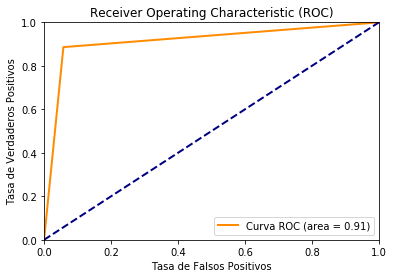

Se han predicho correctamente 119 registros de un total de 131.
Área bajo la curva (AUC): 0.91


In [11]:
# Predicción del clasificador
predicho = clasificador_nb.predict(df_test[claves_predictoras])
esperado = df_test.democrat

roc_auc, _, _ = calcular_y_representar_curva_roc(esperado, predicho)

print('Se han predicho correctamente {} registros de un total de {}.'
      .format(sum(predicho == esperado), esperado.count()))
print('Área bajo la curva (AUC): {:0.2f}'.format(roc_auc))

### Otros clasificadores Naive Bayes

A modo de prueba, se van a entrenar otros dos clasificadores: `BernoulliNB` y `MultinomialNB`, y a comparar los resultados obtenidos para los tres clasificadores.

#### Bernoulli NB

Según la [documentación oficial](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) de *scikit-learn* para el clasificador `BernoulliNB`, este clasificador es bueno cuando se manejan variables independientes discretas binarias.

Este no es el caso, dado que cada feature puede tener el valor `y`, `n` o `?`, por lo que se espera que los resultados no sean especialmente buenos.

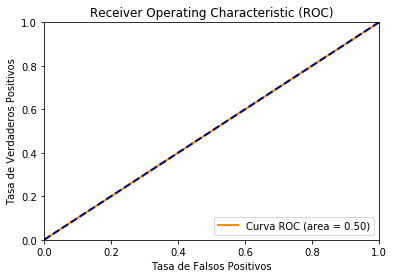

Área bajo la curva (AUC): 0.50


In [12]:
bernoulli_nb = BernoulliNB()
bernoulli_nb.fit(df_train[claves_predictoras].values,
                 df_train[clave_predecir])

predicho_bernoulli = bernoulli_nb.predict(df_test[claves_predictoras])

roc_auc, _, _ = calcular_y_representar_curva_roc(esperado, predicho_bernoulli)

print('Área bajo la curva (AUC): {:0.2f}'.format(roc_auc))

#### Multinomial NB

Según la [documentación oficial](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) de *scikit-learn* para el clasificador `MultinomialNB`, este clasificador es bueno cuando se manejan variables independientes discretas.

Se espera que este clasificador se comporte mejor que el clasificador de `BernoulliNB` dado que `MultinomialNB` no está especializado en valores binarios.

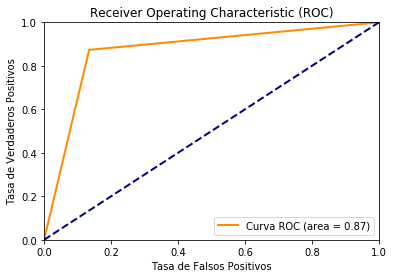

Área bajo la curva (AUC): 0.87


In [13]:
multinomial_nb = MultinomialNB()
multinomial_nb.fit(df_train[claves_predictoras].values,
                   df_train[clave_predecir])

predicho_multinomial = multinomial_nb.predict(df_test[claves_predictoras])

roc_auc, _, _ = calcular_y_representar_curva_roc(esperado, predicho_multinomial)

print('Área bajo la curva (AUC): {:0.2f}'.format(roc_auc))

### Extra - Binarización de variables categóricas

En lugar de asignar los valores numéricos `1`, `2` y `3` a los resultados `y`, `n` y `?`, se va a proceder a separar cada una de las columnas en tres columnas binarias cada una de ellas asociada a un valor distinto, es decir, `c1` se separará en `c1_y`, `c1_n` y `c1_?`.

Cada una de estas nuevas columnas sólo podrá tener los valores `1` o `0` en función de si el valor original era `y`, `n` o `?` y serán mutuamente excluyentes.

En este caso, es de esperar que el clasificador `BernoulliNB` ofrezca mejores resultados.

In [14]:
# Se carga de nuevo el archivo
df = pd.read_csv(nombre_dataset,
                 names=[clave_predecir] + claves_predictoras,
                 header=None)

# De nuevo se predecirá 1 si es demócrata o 0 si no lo es
df['democrat'] = np.where(df['democrat'] == 'democrat', 1, 0)

# Se separan las columnas por categorías
series = [df['democrat']]
for predictor in claves_predictoras:
    series.append(separar_categorias(df, predictor))

# Se crea el dataframe por categorías
df_categorias = pd.concat(series, axis=1, sort=False)

# Se obtienen los conjuntos de entrenamiento y validación como se hizo previamente
df_categorias_train, df_categorias_test = train_test_split(df_categorias, test_size=0.3, shuffle=False)

# Muestra el nuevo esquema del dataframe
df_categorias.head()

,democrat,c1_?,c1_n,c1_y,c2_?,c2_n,c2_y,c3_?,c3_n,c3_y,...,c13_y,c14_?,c14_n,c14_y,c15_?,c15_n,c15_y,c16_?,c16_n,c16_y
0,0,0,1,0,0,0,1,0,1,0,...,1,0,0,1,0,1,0,0,0,1
1,0,0,1,0,0,0,1,0,1,0,...,1,0,0,1,0,1,0,1,0,0
2,1,1,0,0,0,0,1,0,0,1,...,1,0,0,1,0,1,0,0,1,0
3,1,0,1,0,0,0,1,0,0,1,...,1,0,1,0,0,1,0,0,0,1
4,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,1,0,0,1


Una vez están los datos preparados se vuelven a probar los distintos clasificadores, es decir: `GaussianNB`, `BernoulliNB` y `MultinomialNB` para ver si los resultados han mejorado o empeorado con este sistema de conversión de variables categóricas a numéricas, y para ver si el ranking de clasificadores ha cambiado.

AUC Clasificador GaussianNB: 0.91
AUC Clasificador BernoulliNB: 0.90
AUC Clasificador MultinomialNB: 0.90


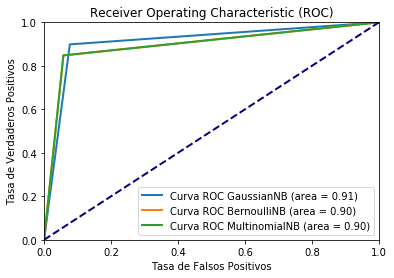

In [15]:
# Se obtienen los nombres de las columnas de las nuevas features
predictores = list(df_categorias_train.columns[1:])

# Se obtienen los valores esperados
esperado = df_categorias_test.democrat

# Valores de métrica
roc_auc = dict()
fpr = dict()
tpr = dict()

# Clasificador GaussianNB
gaussian_nb = GaussianNB()
## Entrenamiento
gaussian_nb.fit(df_categorias_train[predictores].values,
                df_categorias_train[clave_predecir])
## Predicción
predicho_gaussian = gaussian_nb.predict(df_categorias_test[predictores])
## Validación
roc_auc['GaussianNB'], fpr['GaussianNB'], tpr['GaussianNB'] = \
    calcular_y_representar_curva_roc(esperado, predicho_gaussian, representar_curva=False)
print('AUC Clasificador GaussianNB: {:0.2f}'.format(roc_auc['GaussianNB']))

# Clasificador BernoulliNB
bernoulli_nb = BernoulliNB()
## Entrenamiento
bernoulli_nb.fit(df_categorias_train[predictores].values,
                 df_categorias_train[clave_predecir])
## Predicción
predicho_bernoulli = bernoulli_nb.predict(df_categorias_test[predictores])
## Validación
roc_auc['BernoulliNB'], fpr['BernoulliNB'], tpr['BernoulliNB'] = \
    calcular_y_representar_curva_roc(esperado, predicho_bernoulli, representar_curva=False)
print('AUC Clasificador BernoulliNB: {:0.2f}'.format(roc_auc['BernoulliNB']))

# Clasificador MultinomialNB
multinomial_nb = MultinomialNB()
## Entrenamiento
multinomial_nb.fit(df_categorias_train[predictores].values,
                   df_categorias_train[clave_predecir])
## Predicción
predicho_multinomial = multinomial_nb.predict(df_categorias_test[predictores])
## Validación
roc_auc['MultinomialNB'], fpr['MultinomialNB'], tpr['MultinomialNB'] = \
    calcular_y_representar_curva_roc(esperado, predicho_multinomial, representar_curva=False)
print('AUC Clasificador MultinomialNB: {:0.2f}'.format(roc_auc['MultinomialNB']))

# Rrepresentación de las tres curvas juntas
representar_curva_roc(fpr, tpr, roc_auc)

### Conclusiones

- Tras comparar los tres clasificadores resulta curioso ver que el que mejor resultados ofrece es el clasificador `GaussianNB` (`0.91`), cuando según la [documentación oficial](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) este clasificador está diseñado para variables contínuas que sigan una distribución gaussiana.

- No resulta tan extraño comprobar que el clasificador `BernoulliNB` (`0.50`) es el que peor resultados ofrece dado que las features empleadas no son binarias. De hecho, un valor de `0.50` indica para la métrica AUC que se trata de un clasificador puramente aleatorio.

- Por otro lado, cabría esperar que el clasificador que debería dar mejores resultados es el `MultinomialNB` (`0.87`) dado que los datos siguen una distribución discreta, pero se ha visto que el que mejor resultados ofrece es el `GaussianNB` (`0.91`). No obstante, no queda lejos del resultado obtenido por el clasificador gaussiano.

- Es interesante ver que con el segundo sistema para pasar las variables categóricas a numéricas ([Binarización de variables categóricas](#Extra---Binarización-de-variables-categóricas)) los tres clasificadores tienen un porcentaje de aciertos mucho más parejo habiendo mejorado significativamente el clasificador `BernoulliNB`

  - GaussianNB: `0.91`
  - BernoulliNB: `0.90`
  - MultinomialNB: `0.90`

- Igual de interesante es que con el segundo sistema los clasificadores `BernoulliNB` y `MultinomialNB` tienen el mismo porcentaje de acierto cuando cabría esperar que el de `BernoulliNB` fuese mejor dado que se trata de variables binarias. Y no deja de llamar la atención que el clasificador `GaussianNB` sigue siendo el que mejor resultados ofrece.

- La desventaja de este segundo sistema para convertir variables categóricas a numéricas es que tiene un alto coste en lo que a consumo de memoria se refiere. Sobre todo cuando los posibles valores de cada categoría son muchos.